# Population Growth and Migration

On a recent run I was talking with a friend from Spain about immigration in Europe.
We speculated about whether the population of Spain would be growing or shrinking if there were no international migration.
I thought it might be shrinking, but we were not sure.
Fortunately, Our World in Data has just the information we need!

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/migration.ipynb).

In [1]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate


## Data

The following dataset is from OWID's interactive graph, ["Population growth rate with and without migration"](https://ourworldindata.org/grapher/population-growth-rate-with-and-without-migration), ultimately from [UN, World Population Prospects (2022)](https://population.un.org/wpp/Download/) and processed by Our World in Data.

This dataset includes "The annual change in population with migration included versus the change if there was zero migration (neither emigration nor immigration). The latter, therefore, represents the population change based only on domestic births and deaths."

In [4]:
filename = 'population-growth-rate-with-and-without-migration.csv'
download(
    f"https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/{filename}"
)

In [5]:
df = pd.read_csv(filename)
df.columns

Index(['Entity', 'Code', 'Year',
       'Growth rate - Sex: all - Age: all - Variant: estimates',
       'Natural growth rate - Sex: all - Age: all - Variant: estimates'],
      dtype='object')

I'll look at data going back to 1990.

In [6]:
recent = df.query('Year >= 1990')

In [7]:
growth_with = 'Growth rate - Sex: all - Age: all - Variant: estimates'
growth_without = 'Natural growth rate - Sex: all - Age: all - Variant: estimates'

Here are the results for Spain.

In [8]:
country = 'Spain'
group = recent.query(f'Entity == "{country}"')
group.index = group['Year']

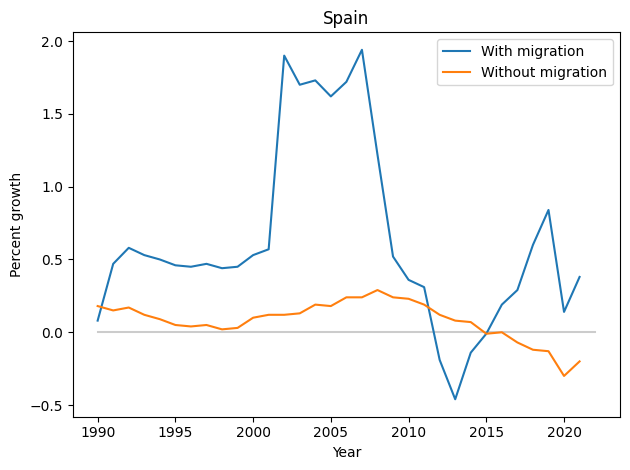

In [9]:
plt.plot([1990, 2022], [0, 0], color='gray', alpha=0.4)
group[growth_with].plot(label='With migration')
group[growth_without].plot(label='Without migration')
decorate(title=country, ylabel='Percent growth')
plt.savefig('migration0.png')

In this graph, we can see:

* Without migration, population growth would have been close to zero -- and negative since 2015.

* With migration, population growth has been substantially higher except for a few years from 2012 to 2014, during a period of high unemployment and austerity measures following the global financial crisis.

I'm not sure what caused the increased migration around 2001.
At first I thought it might be when several Eastern European and Baltic countries joined the EU, but that was not until 2004.
If anyone knows the reason, let me know.

From the annual growth rates, we can compute the cumulative growth over the 32-year period.

In [10]:
def cumulative_growth(df, column):
    if np.sum(df[column].notna()) != 32:
        return np.nan

    total = np.prod(df[column] / 100 + 1)
    return (total - 1) * 100

In [11]:
func_with = lambda df: cumulative_growth(df, growth_with)
func_without = lambda df: cumulative_growth(df, growth_without)

In [12]:
func_with(group), func_without(group)

(22.220158999304985, 2.640377586994469)

With migration, Spain grew by 22% over 32 years, which is very slow.
Without migration, it would have grown by only 2.6%.

So the answer to our question is that the population of Spain would have grown very slowly without migration -- but it is so close to zero, we were probably right to be unsure if it was negative.

## All Countries

Looking across all countries and regions, we can see more general patterns.

In [13]:
grouped = recent.groupby('Entity')
series_with = grouped.apply(func_with)
series_without = grouped.apply(func_without)

In [14]:
growth_df = pd.DataFrame({'With migration': grouped.apply(func_with),
                          'Without migration': grouped.apply(func_without)})
growth_df

With migration  Without migration
Entity                                           
Afghanistan         257.396455         192.150139
Africa (UN)         121.667821         126.761340
Albania             -13.493972          30.935609
Algeria              75.778622          80.857438
American Samoa       -6.238915          94.587084
...                        ...                ...
Western Sahara      217.523019          71.365464
World                50.282098          50.296939
Yemen               150.624385         169.191726
Zambia              156.554019         159.861461
Zimbabwe             61.126891          99.346088

[255 rows x 2 columns]

In [15]:
growth_df.loc['Europe (UN)']

With migration       3.320313
Without migration   -2.129723
Name: Europe (UN), dtype: float64

In [16]:
growth_df.loc['Northern America (UN)']

With migration       36.990776
Without migration    17.732397
Name: Northern America (UN), dtype: float64

Many high-income countries have low fertility rates; without migration, their populations would grow slowly or even shrink.
For example, the population of Europe grew by only 3.3% in 32 years from 1990 to 2022, slower than any other region.
But without migration -- that is, with population change based only on domestic births and deaths -- it would have shrunk by 2.1%.

During the same period, the population of Northern America grew by 37%, much more quickly than Europe.
But more than half of that growth was due to international migration; without it, growth would have been only 18%.

As fertility has decreased, the populations of high-income countries have aged, with fewer employed workers to support more retirees.
These aging populations depend on the labor of immigrants, who tend to be younger, willing to work at jobs some native-born workers would not, and providing skills in areas where there are shortages, including child care and health care.

However, in some countries, the immigration levels needed to stabilize the population face political barriers, and even the perception of increased immigration can elicit anti-immigration sentiments.
Particularly in Europe and Northern America, concerns about immigration -- real and imagined -- have contributed to the [growth of right wing populism](https://www.economist.com/special-report/2019/11/14/why-the-arguments-against-immigration-are-so-popular).

The following figure shows actual growth rates with migration on the x-axis, and hypothetical rates without migration on the y-axis.
Countries in the lower-right quadrant are growing only because of migration; without it, they would be shrinking.
They include several European countries and Japan.

In [17]:
# !pip install plotly kaleido

In [18]:
import plotly.express as px
import plotly.io as pio

def label_entity(entity):
    x, y = growth_df.loc[entity]
    fig.add_annotation(
        x=x,
        y=y,
        text=entity,
        showarrow=True,
        arrowhead=0
    )
    
fig = px.scatter(
    growth_df,
    x='With migration',
    y='Without migration',
    hover_name=growth_df.index,
    title='Population growth, 1990-2022, with and without international migration'
)

fig.add_shape(
    type='line',
    x0=-10, y0=-10, x1=200, y1=200,
    line=dict(color='gray', width=1),
    opacity=0.4
)


entities = ['United States', 'Germany', 'Japan', 'Russia', 
            'Canada', 'Switzerland', 'Spain',
            'Dominica', 'Puerto Rico']
for entity in entities:
    label_entity(entity)

fig.update_xaxes(range=[-10, 40])
fig.update_yaxes(range=[-10, 40])

fig.show()
fig.write_image('migration1.png')

Quick check that my way of computing cumulative growth is consistent with population data from
https://www.macrotrends.net/global-metrics/countries/eur/europe/population.

In [19]:
europe_2022 = 743.6
europe_1990 = 721.5

(europe_2022 - europe_1990) / europe_1990 * 100

3.063063063063066

Probably Overthinking It

Copyright 2024 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).